In [3]:
using Pkg;
# Pkg.add("ReactionNetworkImporters");
# Pkg.add("Dictionaries");
# Pkg.add("LaTeXStrings");
# Pkg.add("Statistics");
# Pkg.add("ColorSchemes");
# Pkg.add("IterTools"); 
# Pkg.add("NNlib"); 
# Pkg.add("DifferentialEquations");
# Pkg.add("Plots");
# Pkg.add("Formatting");
# Pkg.add("LinearAlgebra");
# Pkg.add("Noise");
# Pkg.add("Catalyst");

using DifferentialEquations;
using Random;
using Plots;
using Formatting;
using LinearAlgebra;
using Noise;
using ReactionNetworkImporters;
using Dictionaries;
using LaTeXStrings;
using Statistics;
using ColorSchemes;
using Catalyst;
using IterTools;
using NNlib;

nothing

In [ ]:
include("datasets.jl")
train = create_annular_rings_dataset(150)
val = create_annular_rings_dataset(50)

In [ ]:

include("utils.jl")

nothing

In [ ]:
1/sqrt(3)*rand(-2:2, 3, 3)

In [ ]:
DIMS=3
params_orig = create_node_params(DIMS, t0=0.0, t1=3.0)
# params_orig = [3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 1.0]

In [ ]:
function f(u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    _, theta, beta, w, h, _, _ = sequester_params(p)
 
    hvec = ones(length(u))*h
    fmat = (theta*x + beta).*u - u.*u + hvec
    return fmat
end

function forward!(du, u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    fmat = f(u, xAndp, t)
    for i in 1:length(fmat)
        du[i] = fmat[i]
    end
end


# Calculates the final hidden state of the neural ode
function forward_node(u0, xAndp, tspan)
    prob = ODEProblem(forward!, u0, tspan, xAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end


function backward!(du, u, sAndp, t)
    s = sAndp[1:3]
    p = sAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    fmat = -f(u, sAndp, t)
    for i in 1:length(fmat)
        du[i] = fmat[i]
    end
end


function backward_node(s0, sAndp, tspan)
    prob = ODEProblem(backward!, s0, tspan, sAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

In [ ]:
function node_main(params, train, val; DIMS=3, EPOCHS=20, LR=0.001, threshold=nothing)
    for trindex in eachindex(train)
        x, y = get_one(train, trindex)
        # Augment
        x = augment(x, DIMS-length(x))

        for i in eachindex(x)
            x[i] = abs(x[i])
        end
        x[3] = 0.1
        x = [1.02524206638336182, 0.0898539274930954, 0.1]
        println("ODE | Input: $x | Target: $y")
        dims, theta, beta, w, h, t0, t1 = sequester_params(params)
        
        println("params before | ", params)
        xAndp = vcat(x, params)
        tspan = (t0, t1)
        sol = forward_node(x, xAndp, tspan)
        println("Ideal ReLU | ", relu.(x+theta*x + beta))
        println("ODE | z at t=T | ", sol[end])

        z = reshape(sol[end], (DIMS, 1)) 
        s0 = z
        sAndp = vcat(s0, params)
        rtspan = reverse(tspan)
        bsol = backward_node(s0, sAndp, tspan)
        println("ODE | Input: $x ")
        println("ODE | z at t=0 | ", bsol[end])
        println("==================================")
        return sol, bsol
    end
    
end

function neuralode(; DIMS=3)
    # train = create_linearly_separable_dataset(100, linear, threshold=0.0)
    # val = create_linearly_separable_dataset(40, linear, threshold=0.0)
    # val = train   
    sol, bsol = node_main(params_orig, train[1:1], val[1:1], DIMS=DIMS, EPOCHS=30, threshold=0.0, LR=0.001)
    return sol, bsol
end

sol, bsol = neuralode()
print(sol[end])
plot(sol)

In [ ]:
t = 0.8
b = 0.1

xrange = range(-5, 20, 100)
xs = t.*xrange .+ b

function forward!(du, u, p, t)
    # du contains only one z
    x = p[1]
    theta = p[2]
    du[1] = 0.1 + theta*x - u[1]^3
end

function forward_node(u0, p, tspan)
    prob = ODEProblem(forward!, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

zs = []
for x in xrange
    p = vcat([x, t])
    sol = forward_node([x], p, (0.0, 0.1))
    push!(zs, sol.u[end][1])
end

gg = plot(xs, zs, xlabel=L"$\theta x + \beta$", ylabel=L"$\mathbf{z_{ss}}$", label="Final output")
# png(gg, "activation.png")

In [ ]:
t = 0.8
b = 0.1

xrange = range(-5, 20, 100)
xs = t.*xrange .+ b

function forward!(du, u, p, t)
    # du contains only one z
    x = p[1]
    theta = p[2]
    du[1] = 0.1 + theta*x - u[1]^3
end

function forward_node(u0, p, tspan)
    prob = ODEProblem(forward!, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

zs = []
for x in xrange
    p = vcat([x, t])
    sol = forward_node([x], p, (0.0, 0.1))
    push!(zs, sol.u[end][1])
end

gg = plot(xs, zs, xlabel=L"$\theta x + \beta$", ylabel=L"$\mathbf{z_{ss}}$", label="Final output")
# png(gg, "activation.png")

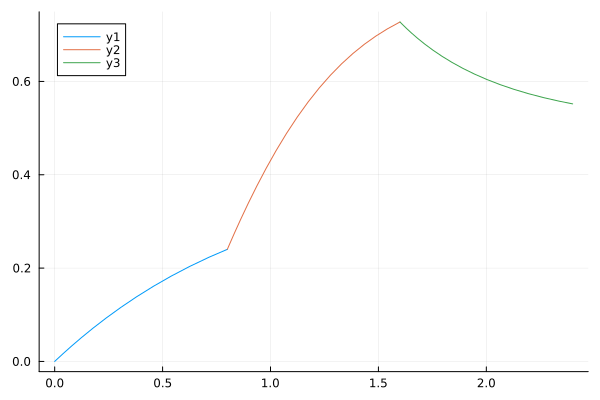

In [57]:
t = 1.0
b = 0.1
xs = randn(3)

function forward!(du, u, p, t)
    # du contains only one z
    x = p[1]
    theta_i = p[2]
    theta_r = p[3]
    theta_f = p[4]
    du[1] = 0.1 + theta_i*x + theta_r*u[1] - theta_f*u[1] - u[1]^3
end

function forward_node(u0, p, tspan)
    prob = ODEProblem(forward!, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

T = 0.8
plot()

i = 0
u0 = [0]
p = abs.(randn(4))
sol = forward_node(u0, p, (i*T, (i+1)*T))
plot!(sol.t, getindex.(sol.u, 1))
i = i+1
u0 = sol.u[end]
p[1] = randn(1)[1]
sol = forward_node(u0, p, (i*T, (i+1)*T))
plot!(sol.t, getindex.(sol.u, 1))
i = i+1
u0 = sol.u[end]
p[1] = randn(1)[1]
sol = forward_node(u0, p, (i*T, (i+1)*T))
plot!(sol.t, getindex.(sol.u, 1))
